In [15]:
import pandas as pd
import datetime as dt
import numpy as np
import scipy.stats as sps
import timeit

In [16]:
df = pd.read_csv('with_variables_v2.csv', index_col = 0)

In [17]:
df.shape

(96397, 429)

## I. Train, test, oot

### 1.1 Get the record numbers to split

In [18]:
time = pd.read_excel('card transactions.xlsx')

In [19]:
time.dtypes

Recnum                        int64
Cardnum                       int64
Date                 datetime64[ns]
Merchnum                     object
Merch description            object
Merch state                  object
Merch zip                   float64
Transtype                    object
Amount                      float64
Fraud                         int64
dtype: object

In [20]:
time1 = time[(time.Date >= pd.to_datetime('2010-01-01') + dt.timedelta(14)) & (time.Date < pd.to_datetime('2010-11-01'))]

In [21]:
time1[(time1.Transtype == 'P') & (time1.Amount < 3102045)]

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud
3344,3345,5142289869,2010-01-15,602608969534,FISHER SCI ATL,GA,30091.0,P,333.47,0
3345,3346,5142148452,2010-01-15,5509006296254,FEDEX SHP 01/10/10 AB#,TN,38118.0,P,4.37,0
3346,3347,5142184598,2010-01-15,680655463,MC MASTER CARR SUPP,IL,60126.0,P,271.93,0
3347,3348,5142148452,2010-01-15,5509006296254,FEDEX SHP 01/10/10 AB#,TN,38118.0,P,3.62,0
3348,3349,5142195887,2010-01-15,4503082616100,OFFICE DEPOT #122,NC,27707.0,P,16.28,0
...,...,...,...,...,...,...,...,...,...,...
84294,84295,5142130739,2010-10-31,9108347680000,STAPLES NATIONAL #471,NJ,7606.0,P,299.77,0
84295,84296,5142219772,2010-10-31,6855293370648,PRESTIGE OFFICE PRODUCTS,NC,27705.0,P,609.34,0
84296,84297,5142257707,2010-10-31,300025852,AMERICAN SOCIETY OF AG,WI,53711.0,P,235.00,0
84297,84298,5142168022,2010-10-31,607900047334,MYSTIC LAKE CASINO,MN,55372.0,P,600.00,0


### 1.2 Standarization

In [24]:
df.head()

,Fraud,Dow_Risk,Cardnum_day_since,Cardnum_count_0,Cardnum_avg_0,Cardnum_max_0,Cardnum_med_0,Cardnum_total_0,Cardnum_actual/avg_0,Cardnum_actual/max_0,...,merch_zip_count_0_by_30,merch_zip_count_1_by_7,merch_zip_count_1_by_14,merch_zip_count_1_by_30,merch_state_count_0_by_7,merch_state_count_0_by_14,merch_state_count_0_by_30,merch_state_count_1_by_7,merch_state_count_1_by_14,merch_state_count_1_by_30
Recnum,,,,,,,,,,,,,,,,,,,,,
1,0,0.022419,0.0,1,3.62,3.62,3.62,3.62,1.0,1.0,...,30.0,7.0,14.0,30.0,7.0,14.0,30.0,7.0,14.0,30.0
2,0,0.022419,0.0,1,31.42,31.42,31.42,31.42,1.0,1.0,...,30.0,7.0,14.0,30.0,7.0,14.0,30.0,7.0,14.0,30.0
3,0,0.022419,0.0,1,178.49,178.49,178.49,178.49,1.0,1.0,...,30.0,7.0,14.0,30.0,7.0,14.0,30.0,7.0,14.0,30.0
4,0,0.022419,0.0,1,3.62,3.62,3.62,3.62,1.0,1.0,...,30.0,7.0,14.0,30.0,7.0,14.0,30.0,7.0,14.0,30.0
5,0,0.022419,0.0,2,3.62,3.62,3.62,7.24,1.0,1.0,...,30.0,7.0,14.0,30.0,7.0,14.0,30.0,7.0,14.0,30.0


In [25]:
from sklearn.preprocessing import StandardScaler

In [42]:
fraud_labels = df.Fraud.values

trn_tst = df.loc[:84299, :].copy()
oot = df.loc[84300:, :].copy()

scaler = StandardScaler()

X = trn_tst.iloc[:,1:]
y = trn_tst.iloc[:,0]
X_oot = oot.iloc[:,1:]
y_oot = oot.iloc[:,0]

scaler.fit(X)
X = scaler.transform(X)
X_oot = scaler.transform(X_oot)

In [43]:
trn_tst = pd.DataFrame(X, columns = trn_tst.columns[1:], index = trn_tst.index)
trn_tst['Label'] = y.values
oot = pd.DataFrame(X_oot, columns = oot.columns[1:], index = oot.index)
oot['Label'] = y_oot.values

In [44]:
trn_tst_fs = trn_tst.loc[3345:,:].copy()

In [45]:
trn_tst_fs['Random'] = np.random.uniform(size = len(trn_tst_fs))

In [47]:
trn_tst_fs

,Dow_Risk,Cardnum_day_since,Cardnum_count_0,Cardnum_avg_0,Cardnum_max_0,Cardnum_med_0,Cardnum_total_0,Cardnum_actual/avg_0,Cardnum_actual/max_0,Cardnum_actual/med_0,...,merch_zip_count_1_by_14,merch_zip_count_1_by_30,merch_state_count_0_by_7,merch_state_count_0_by_14,merch_state_count_0_by_30,merch_state_count_1_by_7,merch_state_count_1_by_14,merch_state_count_1_by_30,Label,Random
Recnum,,,,,,,,,,,,,,,,,,,,,
3345,3.147032,-0.256413,-0.245327,-0.085691,-0.161047,-0.069780,-0.116868,-0.004555,0.442165,-0.041820,...,-1.342291,-1.045068,-1.343806,-1.159222,-0.946936,-1.690503,-1.341056,-1.043526,0,0.908474
3346,3.147032,-0.256413,-0.245327,-0.533379,-0.475489,-0.522439,-0.207308,-0.004555,0.442165,-0.041820,...,-1.421904,-1.122882,-1.503243,-1.234763,-1.023105,-1.867899,-1.420697,-1.121401,0,0.023181
3347,3.147032,-0.256413,-0.245327,-0.169407,-0.219846,-0.154425,-0.133780,-0.004555,0.442165,-0.041820,...,-0.819109,-0.533710,-0.651702,-1.049620,-0.836423,1.004708,-0.817684,-0.531765,0,0.867429
3348,3.147032,-0.317936,-0.082740,-0.533889,-0.475489,-0.522955,-0.206314,-0.216292,-0.164229,-0.051123,...,-1.413244,-1.114418,-1.489796,-1.226547,-1.014820,-1.852937,-1.412035,-1.112931,0,0.078198
3349,3.147032,0.543389,-0.245327,-0.517177,-0.464109,-0.506058,-0.204035,-0.004555,0.442165,-0.041820,...,-0.900644,-0.613402,-0.651702,-0.740158,-0.524388,-0.920442,-0.899248,-0.611520,0,0.799726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84295,-0.074160,1.097098,-0.245327,-0.131535,-0.193246,-0.116133,-0.126129,-0.004555,0.442165,-0.041820,...,-1.077303,-0.906184,-0.775292,-0.907783,-0.810985,-1.057953,-1.075971,-0.904533,0,0.835236
84296,-0.074160,-0.317936,-0.082740,-0.002452,0.102535,0.014383,0.008406,1.222464,0.442165,0.012096,...,0.083597,-0.613402,0.213427,0.193756,-0.524388,0.042133,0.085351,-0.611520,0,0.074865
84297,-0.074160,-0.133366,-0.245327,-0.219644,-0.255131,-0.205221,-0.143928,-0.004555,0.442165,-0.041820,...,1.219261,1.458596,1.078556,1.271349,1.503842,1.004708,1.221427,1.462112,0,0.127687


In [49]:
goods = trn_tst_fs[trn_tst_fs.Label == 0]
bads = trn_tst_fs[trn_tst_fs.Label == 1]

In [50]:
goods.shape, bads.shape

((79764, 430), (868, 430))

In [51]:
len(bads)/len(trn_tst_fs)

0.010764956840956444

## II. Filter

### 2.1 KS score

In [52]:
ks_score = []
for column in trn_tst_fs:
    ks_score.append(sps.ks_2samp(goods[column], bads[column])[0])

### 2.2 FDR

In [54]:
numbads = len(bads)
topRows = int(round(len(trn_tst_fs)*0.03))

In [55]:
trn_tst_fs['check_label'] = trn_tst_fs.Label.values
fdr = []

for column in trn_tst_fs.columns[:-1]:
    temp1 = trn_tst_fs[[column, 'check_label']].sort_values(column, ascending = False).head(topRows)
    temp2 = trn_tst_fs[[column, 'check_label']].sort_values(column, ascending = True).head(topRows)
    FDR1 = temp1.check_label.sum()/numbads
    FDR2 = temp2.check_label.sum()/numbads
    fdr.append(max(FDR1, FDR2))

In [56]:
trn_tst_fs.drop('check_label', axis = 1, inplace = True)

### 2.3 Rankings

In [57]:
rank = pd.DataFrame({
    'Field': trn_tst_fs.columns,
    'KS': ks_score,
    'FDR': fdr
})

In [58]:
rank['KS rank'] = rank.KS.rank()
rank['FDR rank'] = rank.FDR.rank()
rank['Average rank'] = (rank['KS rank'] + rank['FDR rank'])/2

In [59]:
rank.head()

,Field,KS,FDR,KS rank,FDR rank,Average rank
0,Dow_Risk,0.134586,0.063364,29.0,147.5,88.25
1,Cardnum_day_since,0.291223,0.087558,200.0,203.0,201.50
2,Cardnum_count_0,0.339447,0.171659,237.0,250.0,243.50
3,Cardnum_avg_0,0.570021,0.328341,341.0,346.5,343.75
4,Cardnum_max_0,0.585192,0.425115,367.0,369.0,368.00


In [60]:
rank1 = rank.sort_values('KS rank', ascending = False)
rank1

,Field,KS,FDR,KS rank,FDR rank,Average rank
428,Label,1.000000,1.000000,430.0,430.0,430.00
198,card_zip_total_7,0.686372,0.639401,429.0,428.0,428.50
143,card_merch_total_7,0.683319,0.633641,428.0,427.0,427.50
152,card_merch_total_14,0.678014,0.632488,427.0,426.0,426.50
189,card_zip_total_3,0.677927,0.641705,426.0,429.0,427.50
...,...,...,...,...,...,...
407,card_zip_count_1_by_7,0.077092,0.055300,5.0,127.0,66.00
412,card_state_count_0_by_30,0.074863,0.026498,4.0,69.5,36.75
402,card_merch_count_1_by_14,0.057627,0.058756,3.0,141.0,72.00
413,card_state_count_1_by_7,0.053425,0.028802,2.0,79.0,40.50


In [61]:
rank2 = rank.sort_values('FDR rank', ascending = False)
rank2

,Field,KS,FDR,KS rank,FDR rank,Average rank
428,Label,1.000000,1.000000,430.0,430.0,430.00
189,card_zip_total_3,0.677927,0.641705,426.0,429.0,427.50
198,card_zip_total_7,0.686372,0.639401,429.0,428.0,428.50
143,card_merch_total_7,0.683319,0.633641,428.0,427.0,427.50
152,card_merch_total_14,0.678014,0.632488,427.0,426.0,426.50
...,...,...,...,...,...,...
57,Merchnum_count_0,0.226099,0.008065,139.0,5.5,72.25
277,merch_zip_count_0,0.224096,0.008065,138.0,5.5,71.75
110,Merchnum_actual/toal_30,0.163386,0.004608,63.0,2.5,32.75
322,merch_zip_count_30,0.219404,0.004608,134.0,2.5,68.25


In [62]:
rank3 = rank.sort_values('Average rank', ascending = False)
rank3

,Field,KS,FDR,KS rank,FDR rank,Average rank
428,Label,1.000000,1.000000,430.0,430.0,430.00
198,card_zip_total_7,0.686372,0.639401,429.0,428.0,428.50
143,card_merch_total_7,0.683319,0.633641,428.0,427.0,427.50
189,card_zip_total_3,0.677927,0.641705,426.0,429.0,427.50
152,card_merch_total_14,0.678014,0.632488,427.0,426.0,426.50
...,...,...,...,...,...,...
421,merch_zip_count_1_by_30,0.119348,0.014977,17.0,43.5,30.25
426,merch_state_count_1_by_14,0.121626,0.013825,19.0,39.0,29.00
394,Merchnum_count_0_by_30,0.119053,0.013825,14.0,39.0,26.50
396,Merchnum_count_1_by_14,0.121940,0.012673,20.0,31.0,25.50


In [77]:
# rank1.to_excel('rank_by_ks.xlsx', index = False)
# rank2.to_excel('rank_by_fdr.xlsx', index = False)
# rank3.to_excel('rank_by_avg.xlsx', index = False)

## III. Wrapper

In [63]:
filter_results = list(rank3.iloc[1:81,0])

In [64]:
df1 = trn_tst_fs[filter_results].copy()
df1.head()

,card_zip_total_7,card_merch_total_7,card_zip_total_3,card_merch_total_14,card_merch_total_3,card_state_total_3,card_zip_total_14,card_state_total_7,card_merch_total_1,card_zip_total_1,...,merch_state_max_7,Merchnum_max_7,card_merch_avg_3,card_zip_avg_7,Cardnum_avg_1,merch_state_avg_0,merch_zip_max_7,Merchnum_avg_0,merch_zip_avg_0,Cardnum_avg_3
Recnum,,,,,,,,,,,,,,,,,,,,,
3345,0.284582,0.290536,-0.073818,0.268440,-0.070661,-0.095608,0.258636,0.232441,-0.063773,-0.065949,...,0.127248,0.127209,-0.083381,0.318232,0.173777,-0.083184,0.127770,-0.083187,-0.083165,-0.185071
3346,-0.087040,-0.085675,-0.109779,-0.062838,-0.109681,-0.131127,-0.064416,-0.128263,-0.140994,-0.143098,...,-0.576703,-0.576747,-0.488344,-0.504579,-0.098958,-0.507844,-0.576293,-0.507855,-0.507821,-0.588287
3347,-0.031560,-0.026223,-0.015962,0.347053,-0.012739,0.046763,0.336948,0.008478,-0.005236,-0.007468,...,-0.391469,-0.391512,-0.255032,-0.264178,0.024469,-0.162593,-0.391030,-0.162598,-0.162574,0.324389
3348,-0.086209,-0.084843,-0.108939,-0.062017,-0.108841,-0.130298,-0.063598,-0.127456,-0.140145,-0.142249,...,-0.576703,-0.576747,-0.488402,-0.504600,-0.258206,-0.508328,-0.576293,-0.508339,-0.508305,-0.589229
3349,-0.161626,-0.156544,-0.147379,-0.172339,-0.144306,-0.168266,-0.180455,-0.200658,-0.138199,-0.140306,...,-0.324699,-0.324741,-0.474638,-0.490024,-0.558197,-0.492476,-0.324249,-0.492486,-0.492453,-0.601316


In [66]:
labels = trn_tst_fs.Label.values

### Forward selection

In [67]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LogisticRegression

In [68]:
def forward_selection(df, labels, n_features, score = 'accuracy'):

    sfs = SFS(LogisticRegression(),
              k_features = n_features,
              forward = True,
              floating = False,
              scoring = score,
              n_jobs = -1,
              verbose = 0,
              cv = 2)
    sfs.fit(df, labels)
    
    return list(sfs.k_feature_names_)

In [70]:
## From the plot below, I found that 25, 30, 41 are good # of features to go for

start = timeit.default_timer()
features_30 = forward_selection(df1, labels, 30)
print('Total run time: {}mins'.format((timeit.default_timer() - start)/60))

Total run time: 4.374598629016669mins


In [87]:
start = timeit.default_timer()
features_25 = forward_selection(df1, labels, 25)
print('Total run time: {}mins'.format((timeit.default_timer() - start)/60))

Total run time: 3.087833579733312mins


In [88]:
start = timeit.default_timer()
features_41 = forward_selection(df1, labels, 41)
print('Total run time: {}mins'.format((timeit.default_timer() - start)/60))

Total run time: 7.754019616183329mins


In [75]:
sfs_1 = SFS(LogisticRegression(),
              k_features = 50,
              forward = True,
              floating = False,
              scoring = 'accuracy',
              n_jobs = -1,
              verbose = 0,
              cv = 2)
sfs_1.fit(df1, labels)

SequentialFeatureSelector(clone_estimator=True, cv=2,
                          estimator=LogisticRegression(C=1.0, class_weight=None,
                                                       dual=False,
                                                       fit_intercept=True,
                                                       intercept_scaling=1,
                                                       l1_ratio=None,
                                                       max_iter=100,
                                                       multi_class='warn',
                                                       n_jobs=None,
                                                       penalty='l2',
                                                       random_state=None,
                                                       solver='warn',
                                                       tol=0.0001, verbose=0,
                                                       warm_start=False),


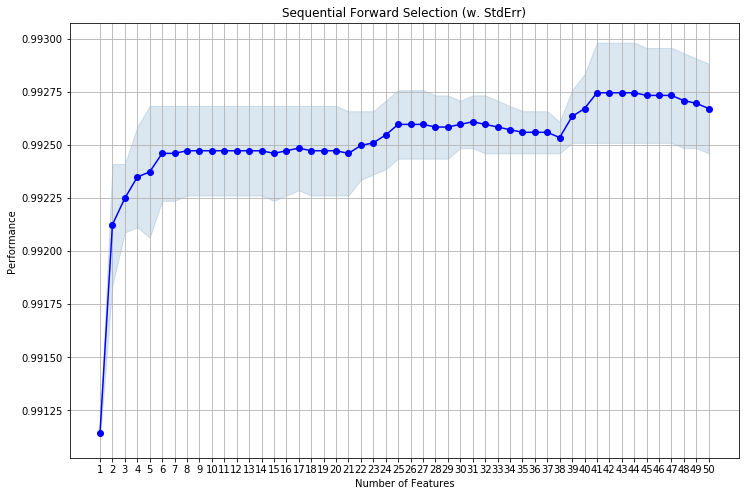

In [80]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

fig = plot_sfs(sfs_1.get_metric_dict(), kind='std_err',figsize=(12,8))

plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

## should we go for higher number of features?

In [96]:
# fig[0].savefig('SFS.png')

### 30 features

In [112]:
final_trn_tst_30 = trn_tst[features_30].copy()
final_trn_tst_30['Label'] = trn_tst.Label.values

In [113]:
final_oot_30 = oot[features_30].copy()
final_oot_30['Label'] = oot.Label.values

In [114]:
# final_trn_tst_30.to_csv('trn_tst_30.csv')
# final_oot_30.to_csv('oot_30.csv')

### 25 features

In [115]:
final_trn_tst_25 = trn_tst[features_25].copy()
final_trn_tst_25['Label'] = trn_tst.Label.values

In [116]:
final_oot_25 = oot[features_25].copy()
final_oot_25['Label'] = oot.Label.values

In [117]:
# final_trn_tst_25.to_csv('trn_tst_25.csv')
# final_oot_25.to_csv('oot_25.csv')